In [1]:
import pyodbc
import get_conf
from datetime import timedelta, date, datetime
import pandas as pd
import os
import xarray as xr
import dask
import matplotlib.pyplot as plt

from xarray.coding.times import decode_cf_datetime

conn = pyodbc.connect(get_conf.conn_string() )

## Example HF tables

- Agali_II_FluxHFdata
- Palo_ClearCut_PaloclearHFdata
- Palo_Forest_TensoHFdata
- Soontaga_HFdata

### Soontaga Forest station - Soontaga_HFdata

We need to plot the following columns:

      ,[w_Avg] – vertical wind (Z), m/s
      ,[T_Avg] – sonic temperature, 0C
      ,[CO2_dry_Avg] - CO2, ppm
      ,[H2O_dry_Avg] – H2O, mmol/mol

In [7]:
days_back = 1
include_now = 1
parameter = "CO2"
station_table = "Palo_Forest_FluxHFdata"
filename_def = 'today_and_yesterday'


In [8]:
d3 = timedelta(days=days_back)

normal_shift = 1 if include_now < 1 else 0

dt_today = date.today() - timedelta(days=normal_shift)

a = dt_today.strftime('%Y-%m-%d 23:59:59') if include_now <= 0 else datetime.now().strftime('%Y-%m-%d %H:%M:%S')

b = (dt_today - d3).strftime('%Y-%m-%d 00:00:00')

a_str = a.replace(' ','_').replace(':','.')
b_str = b.replace(' ','_').replace(':','.')

filename_pref = f"{parameter}_{station_table}_{b_str}_{a_str}" if len(filename_def) <= 0 else f"{filename_def}"

outfilename = f"{filename_pref}.png"

print(a)
print(b)
print(outfilename)

2021-11-22 14:58:57
2021-11-21 00:00:00
today_and_yesterday.png


In [9]:
param = parameter
table = station_table
from_ts = b
to_ts = a

sql_query = f"SELECT {param}, TmStamp FROM {table} WHERE TmStamp >= '{from_ts}' AND TmStamp <= '{to_ts}'"

print(sql_query)

df = pd.read_sql_query(sql_query, conn, coerce_float=True, parse_dates=['TmStamp'], chunksize=None).rename(columns={'TmStamp':'time'}).set_index('time')


SELECT CO2, TmStamp FROM Palo_Forest_FluxHFdata WHERE TmStamp >= '2021-11-21 00:00:00' AND TmStamp <= '2021-11-22 14:58:57'


In [10]:
qr = df.quantile([0.01, 0.99])
qr_min = qr.iloc[0,0]
qr_max = qr.iloc[1,0]

iqrx = (qr_max - qr_min)

vmin = qr_min-iqrx*1.5
vmax = qr_max+iqrx*1.5

print(f"vmin {vmin} vmax {vmax}")

vmin 207.56515716552764 vmax 717.9114242553705


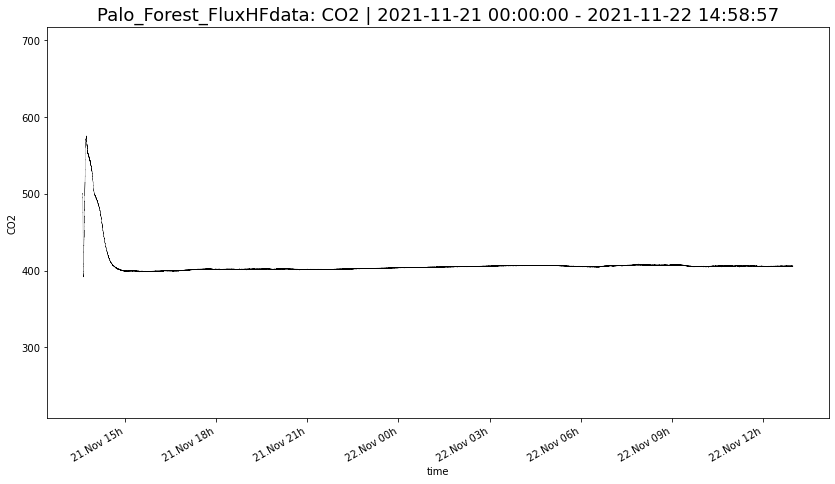

In [11]:
dset = xr.Dataset.from_dataframe(df)

def format_date(x, pos=None):
    calendar = "standard"
    units="days since 1970-01-01 00:00:00"

    np_ts = decode_cf_datetime([x], units, calendar=calendar, use_cftime=None)[0]
    return pd.Timestamp(np_ts).strftime('%d.%b %Hh')


fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.set_ylim(vmin, vmax)
ax.xaxis.set_major_formatter(format_date)
dset[parameter].plot(ax=ax, color='black', lw=0.2)

fig.autofmt_xdate()
plt.title(f"{station_table}: {param} | {from_ts} - {to_ts}", fontsize=18)

plt.savefig(os.path.join( 'images', outfilename) )


In [12]:
print(f"finished plotting {outfilename} at {datetime.now().isoformat()}")

finished plotting today_and_yesterday.png at 2021-11-22T14:59:19.734657
